In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import shap

In [2]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop')+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o")
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

# Parte 1

In [3]:
df_hr = pd.read_csv('Data/hr_role.csv')
df_hr['Attrition'] = df_hr['Attrition'].map({'Yes': 1, 'No': 0})
df_hr = pd.get_dummies(df_hr)


In [4]:
target = 'Attrition'
X = df_hr.copy()
X = X.drop(columns=[target])
y = df_hr[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PCA 

In [5]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [6]:
objeto_pca = pipeline.named_steps['pca']

In [7]:
X_pca = pipeline.transform(X)
X_componentes = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X.shape[1])])
X_componentes.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
0,-0.030304,2.330446,-1.161395,3.217517,-0.113925,-0.253495,-1.040500,-0.309246,-0.448044,-2.111620,...,0.014891,7.021017e-16,-4.196757e-16,1.557119e-15,-6.386010e-16,4.196947e-16,-4.439226e-16,-4.944891e-16,-2.552172e-16,-1.479499e-16
1,0.049651,-1.543678,-0.213908,-1.662470,0.719564,2.208041,1.095471,1.080794,2.427347,-1.248215,...,-0.102855,-3.506487e-16,-5.087771e-16,-4.860947e-16,1.069790e-15,5.818953e-16,4.751109e-16,1.562116e-16,1.214602e-16,2.081245e-16
2,-2.921983,-0.996320,-0.206778,1.584724,-0.095803,-0.098296,-2.782596,-0.838934,0.416457,0.642975,...,-0.099216,7.298573e-16,-6.972314e-16,6.689407e-16,8.046889e-16,1.085828e-15,-1.221079e-15,-8.830672e-16,5.590343e-16,6.847174e-16
3,-1.187400,-1.054261,-0.692836,2.306721,-0.228501,2.392424,1.058589,0.071526,-1.843889,-1.818120,...,0.045951,-8.036383e-16,-1.377243e-15,1.390586e-15,9.157112e-16,-2.464391e-16,9.993673e-16,-1.105112e-15,5.210812e-16,3.794060e-16
4,-2.122667,-1.196360,0.532758,-1.288092,-0.694017,-1.685820,-0.501539,-0.272690,-0.631277,1.714992,...,0.148985,-1.841152e-16,4.210346e-16,-4.305835e-16,7.058972e-17,-5.648298e-17,3.102173e-17,-1.009523e-15,4.840632e-16,-1.249424e-16


In [8]:
explained_variance = objeto_pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance Ratio': explained_variance
})
explained_variance_df = explained_variance_df.sort_values(by='Explained Variance Ratio', ascending=False)
top_10_explained_variance = explained_variance_df.head(10).reset_index(drop=True)
top_10_explained_variance


,Principal Component,Explained Variance Ratio
0,PC1,0.104945
1,PC2,0.068745
2,PC3,0.051695
3,PC4,0.042252
4,PC5,0.041221
5,PC6,0.039242
6,PC7,0.038350
7,PC8,0.035444
8,PC9,0.034967
9,PC10,0.031601


# KMeans

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/

Text(0, 0.5, 'Inertia')

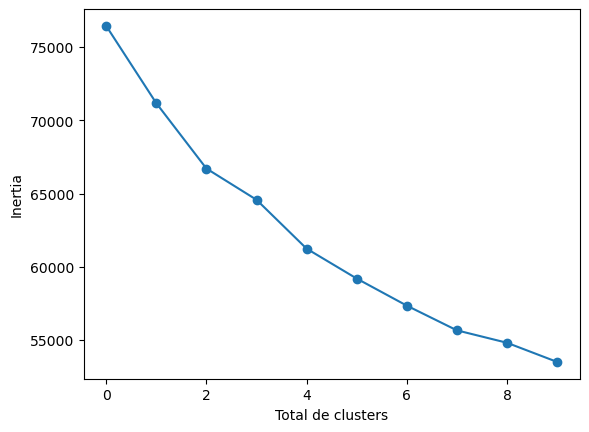

In [9]:
inertias = []

K_range = range(1, 11)
for i in K_range:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=i, random_state=42))
    ])
    pipeline.fit(df_hr)
    inertias.append(pipeline.named_steps['kmeans'].inertia_)

plt.plot(inertias, marker='o')
plt.xlabel('Total de clusters')
plt.ylabel('Inertia')

In [10]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])
pipeline.fit(df_hr)
df_hr['cluster'] = pipeline.predict(df_hr)

df_hr.groupby('cluster').mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
cluster,,,,,,,,,,,,,,,,,,,,,
0,35.150376,0.220551,800.052632,9.388471,2.912281,2.679198,65.192982,2.696742,2.035088,5911.969925,...,0.00000,0.000000,0.786967,0.20802,0.195489,0.453634,0.350877,1.0,0.709273,0.290727
1,45.957529,0.054054,809.146718,8.976834,3.100386,2.698842,66.030888,2.733591,3.884170,14807.872587,...,0.30888,0.003861,0.046332,0.00000,0.247104,0.505792,0.247104,1.0,0.698842,0.301158
2,34.913793,0.166256,801.556650,9.165025,2.853448,2.750000,66.189655,2.745074,1.497537,4144.327586,...,0.00000,0.358374,0.000000,0.00000,0.227833,0.444581,0.327586,1.0,0.726601,0.273399


Al momento de hacer KMeans para el dataset de hr y utilizar 3 clusters podemos ver como las variables se dividen, podemos notar que el cluster que tiene menor attrition es el numero 1 con un 5.4%, algo que podemos notar es que los 3 clusters en la mayoria son muy similares sin embargo donde notamos diferencia entre el cluster 1 y los demas es en la edad promedio de los trabajadores siendo de alrededor de 45 años, en diferencia a los otros dos donde el promedio de edad ronda alrededor de los 35 años, la otra variable donde podemos ver diferencia y sin duda una variable que tiene bastante impacto es en el ingreso mensual de los empleados donde en el cluster 1 el ingreso mensual promedio es de 14,807 y los otros siendo bastante menos. Podriamos decir que entre más gana el empleado mayor probabilidad existe de que este se quede en la empresa.

## LightGBM Todas Variables

In [11]:
model = LGBMClassifier(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], callbacks=[early_stopping(20)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[93]	training's auc: 0.996716	valid_1's auc: 0.78904


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
               num_iterations=10000, num_leaves=10, subsample=0.5,
               verbosity=-1)

In [12]:
best_model = model
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.7890397184514831

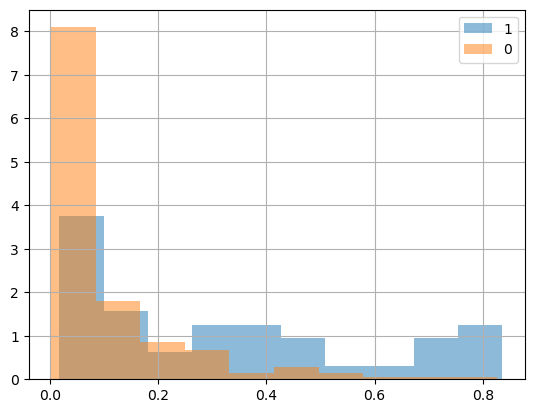

In [13]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

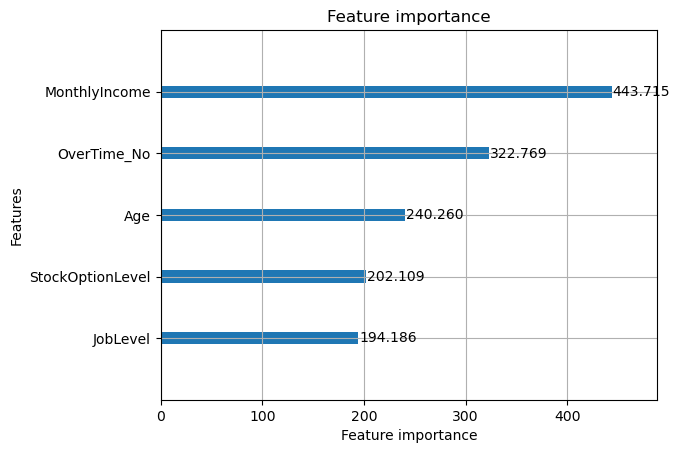

In [14]:
lgb.plot_importance(model, max_num_features=5, importance_type='gain')

In [15]:
X_shap = X_test.sample(100, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


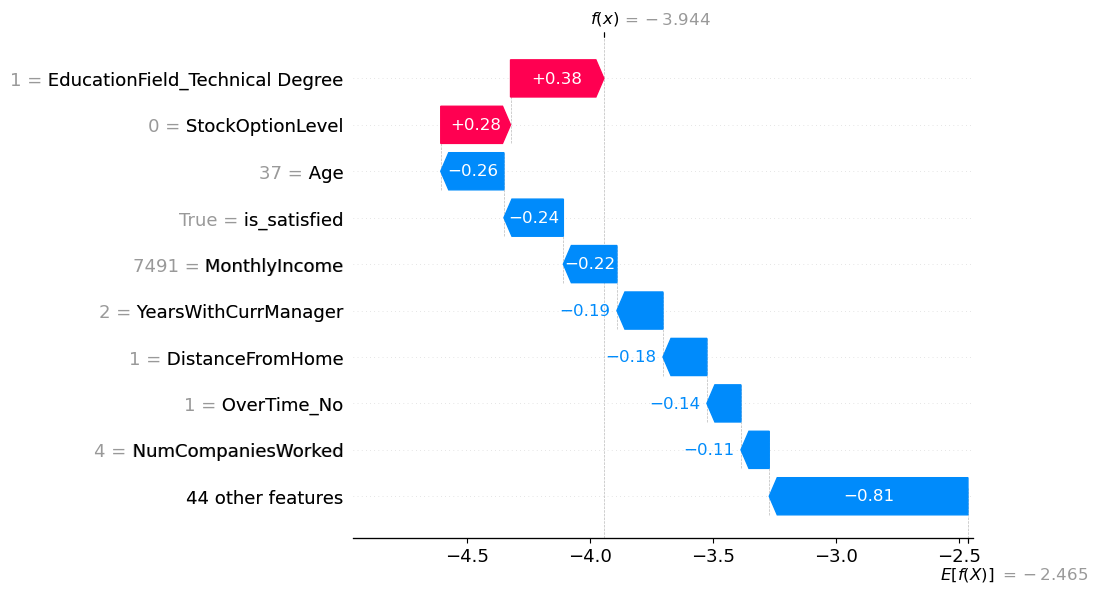

In [16]:
shap.initjs()
# Para visualizar shap individual con waterfall plot
# input: shap.Explanation(values=shaps[0])
shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                    base_values = explainer.expected_value,
                    data=X_shap.iloc[0],
                    feature_names= X_shap.keys()))

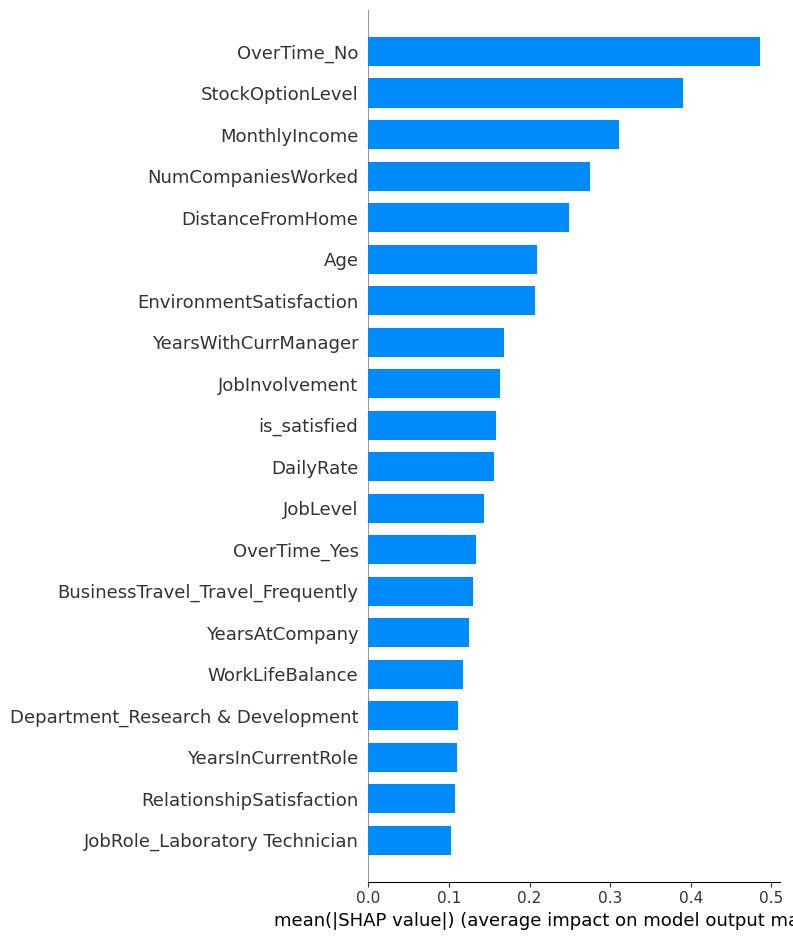

In [17]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

En el Shap values podemos notar que las variables que mas impacto tienen o más influyen a la hora de clasificar en el modelo, son si el empleado trabaja Horas Extra, despues el Stock Option Level y el ingreso mensual. Estas variables son las que influyen bastante a la hora de predecir si una persona se ira de la empresa o no.

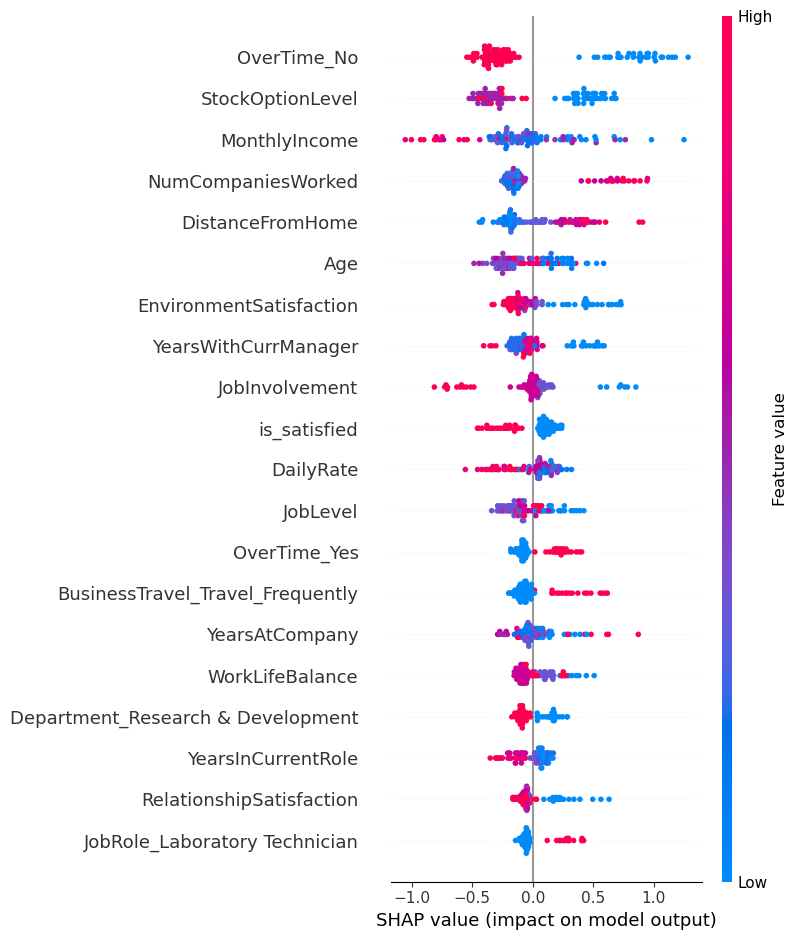

In [18]:
shap.summary_plot(shap_values, X_shap, plot_type="dot")

## LightGBM Todas Las Componentes

In [19]:
XC_train, XC_test, y_train, y_test = train_test_split(X_componentes, y, test_size=0.2, random_state=42)

In [20]:
model = LGBMClassifier(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)
model.fit(XC_train, y_train, eval_set=[(XC_train, y_train), (XC_test, y_test)], callbacks=[early_stopping(20)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	training's auc: 0.988876	valid_1's auc: 0.774661


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
               num_iterations=10000, num_leaves=10, subsample=0.5,
               verbosity=-1)

In [21]:
best_model = model
probabilidades = best_model.predict_proba(XC_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.7746606334841628

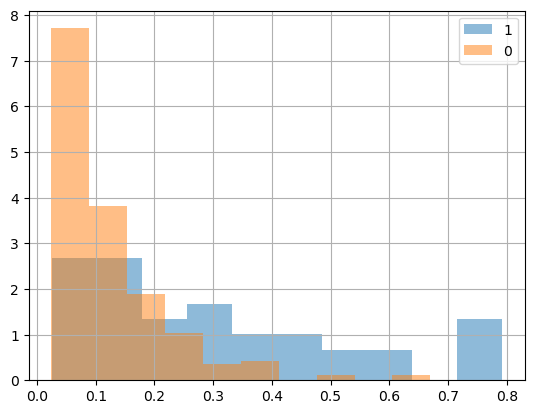

In [22]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

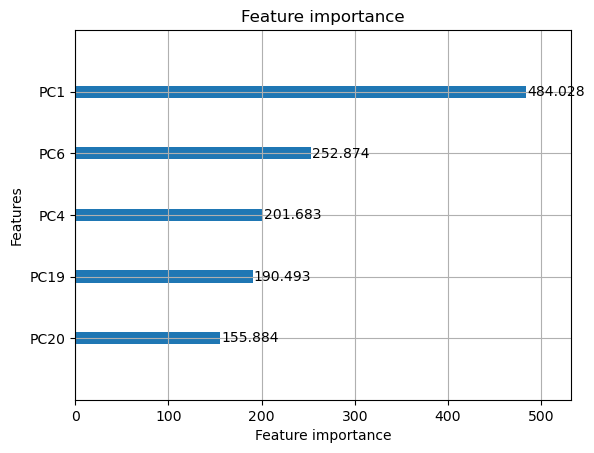

In [23]:
lgb.plot_importance(model, max_num_features=5, importance_type='gain')

De acuerdo al feature importance realizado con los diferentes componentes podemos ver que los mas importantes son el 1, 6, 4, 19 y 20

## LightGBM Componentes Principales

In [24]:
XI_train, XI_test, y_train, y_test = train_test_split(X_componentes[['PC1', 'PC6','PC4','PC19']], y, test_size=0.2, random_state=42)

In [25]:
model = LGBMClassifier(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)
model.fit(XI_train, y_train, eval_set=[(XI_train, y_train), (XI_test, y_test)], callbacks=[early_stopping(20)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's auc: 0.834428	valid_1's auc: 0.666566


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
               num_iterations=10000, num_leaves=10, subsample=0.5,
               verbosity=-1)

In [26]:
best_model = model
probabilidades = best_model.predict_proba(XI_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.6665661136249371

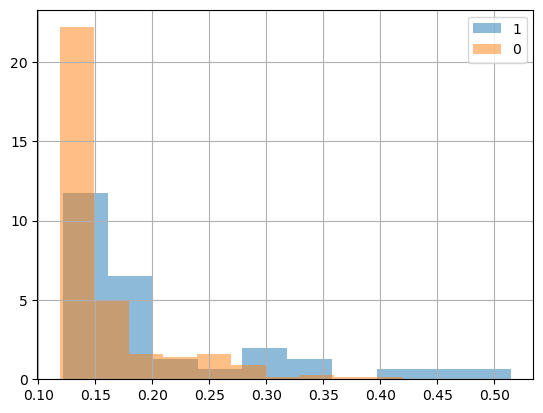

In [27]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

Despues de aplicar el modelo LightGBM con las variables, todas las componentes y las componentes con mas impacto podemos ver que el modelo con mejor AUC fue el de todas las variables con un 0.78 de AUC, despues muy cerca fue el modelo utilizando todas las componentes con un AUC de 0.77 y por ultimo el modelo que dio AUC mas bajo fue el de las componentes principales con un 0.66.

# Parte 2

In [28]:
df_d = pd.read_csv('Data/diabetes.csv')
df_d['smoking_history'] = df_d['smoking_history'].map({'No Info': 0, 'never':0, 'former': 1, 'current': 1, 'not current': 1,
                                                       'ever':1})
df_d = pd.get_dummies(df_d)

In [29]:
target = 'diabetes'
X = df_d.copy()
X = X.drop(columns=[target])
y = df_d[target]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# S Learner

In [31]:
model = LGBMClassifier(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], callbacks=[early_stopping(20)])

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[96]	training's auc: 0.839736	valid_1's auc: 0.835959


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
               num_iterations=10000, num_leaves=10, subsample=0.5,
               verbosity=-1)

In [32]:
x_test_counter0= X_test.copy()
x_test_counter0['smoking_history'] = 0

x_test_counter1 = X_test.copy()
x_test_counter1['smoking_history'] = 1

In [33]:
df_cate = pd.DataFrame({
    'treatment0': model.predict_proba(x_test_counter0)[:,1],
    'treatment1': model.predict_proba(x_test_counter1)[:,1]
})

In [34]:
df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']
df_cate['bin_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes'] = y_test
df_cate.groupby('bin_cate').mean()

,treatment0,treatment1,cate,diabetes
bin_cate,,,,
1,0.011332,0.012022,0.000690,0.073892
2,0.014721,0.020398,0.005677,0.091358
3,0.041414,0.053982,0.012567,0.086358
4,0.106478,0.129614,0.023136,0.106329
5,0.209648,0.251016,0.041368,0.085502


In [35]:
df_cate['cate'].describe()

count    20000.000000
mean         0.016685
std          0.015422
min         -0.041742
25%          0.004668
50%          0.012854
75%          0.026239
max          0.210587
Name: cate, dtype: float64

Haciendo el S Learner vemos que el si fumar que es lo que en este caso estamos viendo si tiene impacto en que una persona tenga diabates, notamos que en promedio aumenta estas posibilidades en 1.66%, llegando a aumentarlas hasta un posible 21.05%. Viendo los bins notamos que los bins son crecientes de una manera no tan exagerada, aunque del bin 1 al 2 si vemos un crecimiento drastico en el efecto causal, aunque la diabetes se queda se podria decir en el mismo rango.

# T Learner

In [36]:
# Train: Promo = 1
X_train_smoking1 = X_train[X_train['smoking_history'] == 1]
y_train_smoking1 = y_train.loc[X_train_smoking1.index]

# Train: Promo = 0
X_train_smoking0 = X_train[X_train['smoking_history'] == 0]
y_train_smoking0 = y_train.loc[X_train_smoking0.index]

# Test: Promo = 1
X_test_smoking1 = X_test[X_test['smoking_history'] == 1]
y_test_smoking1 = y_test.loc[X_test_smoking1.index]

# Test: Promo = 0
X_test_smoking0 = X_test[X_test['smoking_history'] == 0]
y_test_smoking0 = y_test.loc[X_test_smoking0.index]

y_train_smoke = X_train['smoking_history'].reset_index(drop=True)
y_test_smoke = X_test['smoking_history'].reset_index(drop=True)

In [37]:
model_t0 = LGBMClassifier(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)

model_t0.fit(X_train_smoking0, y_train_smoking0, eval_set=[(X_train_smoking0, y_train_smoking0), (X_test_smoking0, y_test_smoking0)], callbacks=[early_stopping(20)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	training's auc: 0.851602	valid_1's auc: 0.84826


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
               num_iterations=10000, num_leaves=10, subsample=0.5,
               verbosity=-1)

In [38]:
model_t1 = LGBMClassifier(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)

model_t1.fit(X_train_smoking1, y_train_smoking1, eval_set=[(X_train_smoking1, y_train_smoking1), (X_test_smoking1, y_test_smoking1)], callbacks=[early_stopping(20)])

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	training's auc: 0.798495	valid_1's auc: 0.794274


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
               num_iterations=10000, num_leaves=10, subsample=0.5,
               verbosity=-1)

In [39]:
todos = X_test.copy()
todos = todos[X_train_smoking0.keys()]

df_cate = pd.DataFrame({
    'treatment0': model_t0.predict_proba(todos)[:,1],
    'treatment1': model_t1.predict_proba(todos)[:,1],
})

In [40]:
df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']
df_cate['bin_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes'] = y_test
df_cate.groupby('bin_cate').mean()

,treatment0,treatment1,cate,diabetes
bin_cate,,,,
1,0.088706,0.084068,-0.004638,0.095179
2,0.020790,0.028727,0.007937,0.077482
3,0.033286,0.046114,0.012828,0.078067
4,0.076895,0.100567,0.023672,0.087629
5,0.161861,0.220127,0.058266,0.105000


In [41]:
df_cate['cate'].describe()

count    20000.000000
mean         0.019591
std          0.026237
min         -0.304127
25%          0.006816
50%          0.012315
75%          0.027662
max          0.276982
Name: cate, dtype: float64

Con el T Learner podemos ver que es similar al S Learner donde calcula que en promedio el fumar aumenta un 1.95% las posibilidades de tener diabetes, con un extremo de 27.69% en algun posible caso. viendo los vins notamos de igual manera u crecimiento se podría decir no tan drastico en el efecto causal, de igual manera el porcentaje de diabetes se mantiene en los mismos valores no vemos cambios tan exagerados.

# X Learner

In [42]:
D0 = y_train_smoking1 - model_t0.predict_proba(X_train_smoking1)[:,1]
D1 = y_train_smoking0 - model_t1.predict_proba(X_train_smoking0)[:,1]

In [43]:
mD0 = LGBMRegressor(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)

mD0.fit(X_train_smoking1, D0)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
              num_iterations=10000, num_leaves=10, subsample=0.5, verbosity=-1)

In [44]:
mD1 = LGBMRegressor(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)

mD1.fit(X_train_smoking0, D1)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
              num_iterations=10000, num_leaves=10, subsample=0.5, verbosity=-1)

In [45]:
X_train_ps = X_train.drop('smoking_history', axis=1)
X_test_ps = X_test.drop('smoking_history', axis=1)

propensity_model = LGBMClassifier(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)

propensity_model.fit(X_train_ps, y_train_smoke, eval_set=[(X_train_ps, y_train_smoke), (X_test_ps, y_test_smoke)], callbacks=[early_stopping(20)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	training's auc: 0.688701	valid_1's auc: 0.689113


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
               num_iterations=10000, num_leaves=10, subsample=0.5,
               verbosity=-1)

(array([3119.,  426.,  494., 2014., 4917., 5582., 1809., 1209.,  364.,
          66.]),
 array([0.01646954, 0.07920316, 0.14193679, 0.20467041, 0.26740404,
        0.33013766, 0.39287129, 0.45560491, 0.51833854, 0.58107216,
        0.64380578]),
 <BarContainer object of 10 artists>)

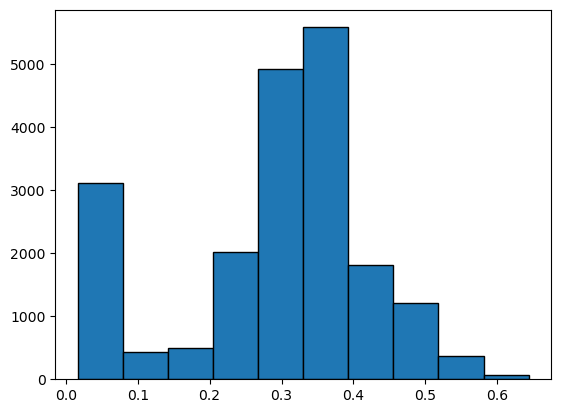

In [46]:
propensity_score = propensity_model.predict_proba(X_test_ps)[:, 1]
plt.hist(propensity_score, bins=10, edgecolor='black')

In [47]:
predict_d1 = mD1.predict(X_test)
predict_d0 = mD0.predict(X_test)

In [48]:
cate = propensity_score * predict_d1 + (1-propensity_score)*predict_d0
cate

array([-0.01972962, -0.00161634,  0.03389077, ...,  0.01674697,
        0.08548984,  0.02324918])

In [49]:
df_cate = pd.DataFrame({
    'cate': cate,   
})
df_cate['bin_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes'] = y_test
df_cate.groupby('bin_cate').mean()


,cate,diabetes
bin_cate,,
1,-0.080902,0.088639
2,-0.015960,0.090800
3,-0.001398,0.087342
4,0.017596,0.084399
5,0.107951,0.091584


In [50]:
df_cate['cate'].describe()

count    20000.000000
mean         0.005380
std          0.076418
min         -0.677307
25%         -0.019631
50%         -0.001480
75%          0.025091
max          0.651882
Name: cate, dtype: float64

Con el X Learner vemos que en promedio el fumar aumenta un 0.5% a las posibilidades de tener diabetes, en este caso vemos que el caso extremo llega a un 65% de aumento, siendo el mas alto de los tres modelos Learners aplicados. En cuanto a los bins vemos un crecimiento tambien moderado en los primeros bins pero en el quinto el crecimiento del efecto causal es bastante alto, igualmente el porcentaje de diabetes se mantiene en casi los mismos valores similar a los demas Learners.